In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [2] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 42.184 MiB


# Ideal Point Estimation

Here we perform Ideal Point Estimation of legislators in 113th Congress.

## Load Data
### Legislators
First we have to load in all legislators (this is for all of time, from GovTrack).

In [3]:
import ideal_point.raw_data

In [3] used 33.844 MiB RAM in 0.659s, peaked 0.000 MiB above current, total RAM usage 76.027 MiB


In [4]:
legislator_df = ideal_point.raw_data.legislators()
legislator_df.head()

,last_name,first_name,birthday,gender,type,state,district,party,url,address,...,thomas_id,opensecrets_id,lis_id,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
0,Brown,Sherrod,1952-11-09,M,sen,OH,NaN,Democrat,https://www.brown.senate.gov,713 Hart Senate Office Building Washington DC ...,...,136.0,N00003535,S307,5051.0,400050,27018.0,Sherrod Brown,NaN,29389.0,Sherrod Brown
1,Cantwell,Maria,1958-10-13,F,sen,WA,NaN,Democrat,https://www.cantwell.senate.gov,511 Hart Senate Office Building Washington DC ...,...,172.0,N00007836,S275,26137.0,300018,27122.0,Maria Cantwell,NaN,39310.0,Maria Cantwell
2,Cardin,Benjamin,1943-10-05,M,sen,MD,NaN,Democrat,https://www.cardin.senate.gov,509 Hart Senate Office Building Washington DC ...,...,174.0,N00001955,S308,4004.0,400064,26888.0,Ben Cardin,NaN,15408.0,Ben Cardin
3,Carper,Thomas,1947-01-23,M,sen,DE,NaN,Democrat,http://www.carper.senate.gov,513 Hart Senate Office Building Washington DC ...,...,179.0,N00012508,S277,663.0,300019,22421.0,Tom Carper,NaN,15015.0,Tom Carper
4,Casey,Robert,1960-04-13,M,sen,PA,NaN,Democrat,https://www.casey.senate.gov,393 Russell Senate Office Building Washington ...,...,1828.0,N00027503,S309,47036.0,412246,2541.0,"Bob Casey, Jr.",NaN,40703.0,Bob Casey Jr.


In [4] used 8.512 MiB RAM in 0.178s, peaked 0.750 MiB above current, total RAM usage 84.539 MiB


### Votes

Next we can load in all the votes. We get two dataframes from this, `vote_df` and `position_df`.

Each row of `vote_df` corresponds to one roll call vote (like on the passage of a bill).

Each row of `position_df` corresponds to one legislators position on a vote.

In [5]:
vote_df, position_df = ideal_point.raw_data.votes(legislator_df)


In [5] used 197.203 MiB RAM in 36.445s, peaked 26.590 MiB above current, total RAM usage 281.742 MiB


In [6]:
vote_df.head()

,amendment,bill,category,chamber,congress,date,nomination,number,question,record_modified,requires,result,result_text,session,source_url,subject,type,updated_at,vote_id
0,NaN,NaN,quorum,h,113,2013-01-03T12:24:00-05:00,NaN,1,Call of the House,NaN,QUORUM,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll001.xml,NaN,Call of the House,2014-06-18T11:22:24-04:00,h1-113.2013
1,NaN,NaN,procedural,h,113,2013-01-14T19:18:00-05:00,NaN,10,On Motion to Adjourn,NaN,1/2,Failed,Failed,2013,http://clerk.house.gov/evs/2013/roll010.xml,NaN,On the Motion to Adjourn,2014-06-18T11:22:23-04:00,h10-113.2013
2,NaN,"{'type': 'hr', 'congress': 113, 'number': 1120}",recommit,h,113,2013-04-12T12:00:00-04:00,NaN,100,On Motion to Recommit with Instructions: H R 1...,NaN,1/2,Failed,Failed,2013,http://clerk.house.gov/evs/2013/roll100.xml,Preventing Greater Uncertainty in Labor-Manage...,On the Motion to Recommit,2014-06-18T11:22:04-04:00,h100-113.2013
3,NaN,"{'type': 'hr', 'congress': 113, 'number': 1120}",passage,h,113,2013-04-12T12:10:00-04:00,NaN,101,On Passage: H R 1120 Preventing Greater Uncert...,NaN,1/2,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll101.xml,Preventing Greater Uncertainty in Labor-Manage...,On Passage of the Bill,2014-06-18T11:22:04-04:00,h101-113.2013
4,NaN,NaN,procedural,h,113,2013-04-12T12:17:00-04:00,NaN,102,On Approving the Journal,NaN,1/2,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll102.xml,NaN,On Approving the Journal,2014-06-18T11:22:04-04:00,h102-113.2013


In [6] used 0.211 MiB RAM in 0.063s, peaked 0.000 MiB above current, total RAM usage 281.953 MiB


In [7]:
position_df.head()

,legislator_index,position,vote_index
0,39,Present,0
1,12270,Present,0
2,40,Present,0
3,376,Present,0
4,12276,Present,0


In [7] used 0.000 MiB RAM in 0.017s, peaked 0.000 MiB above current, total RAM usage 281.953 MiB


## Transform Data

Next we have to transform our data to a format we can train our model on.

Our observed data is basically `position_df`. but instead of categorical `position`s, we need them to
be 1s and 0s. Also, since we aren't using all of the legislators, we need to transform
the `legislator_index` into a relative index. We call this transformed dataframe `model_position_df`.

In [29]:
import ideal_point.ideal_point

In [29] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 738.070 MiB


In [42]:
model_position_df, model_legislator_index, model_vote_index = ideal_point.ideal_point.transform_data(position_df, vote_df, legislator_df)

In [42] used 26.715 MiB RAM in 1.603s, peaked 45.871 MiB above current, total RAM usage 832.270 MiB


In [43]:
model_position_df.head()

,legislator,position,vote
0,39,0,0
1,530,0,0
2,40,0,0
3,375,0,0
4,0,0,0


In [43] used 0.000 MiB RAM in 0.010s, peaked 0.000 MiB above current, total RAM usage 832.270 MiB


In [44]:
model_position_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508555 entries, 0 to 508554
Data columns (total 3 columns):
legislator    508555 non-null int64
position      508555 non-null int64
vote          508555 non-null int64
dtypes: int64(3)
memory usage: 11.6 MB
In [44] used 0.000 MiB RAM in 0.011s, peaked 0.000 MiB above current, total RAM usage 832.270 MiB


The two series `model_legislator_index` and `model_vote_index` map the values in `model_position_df` to the full dataframes, from index to value.

## Create Model

Now we can create our model, given we have observed those votes. The notation is based
on ["Comparing NOMINATE and IDEAL: Points of Difference and Monte Carlo Tests"](http://scholar-qa.princeton.edu/sites/default/files/jameslo/files/lsq_nomvsideal.pdf).

In [45]:
model = ideal_point.ideal_point.create_model(model_position_df)

In [45] used 26.930 MiB RAM in 0.333s, peaked 0.000 MiB above current, total RAM usage 859.199 MiB


## Train Model

Now we can run variational inference to compute estimated parameters for the model.

In [46]:
# advi_params = ideal_point.ideal_point.advi_params(model)
# ideal_point.ideal_point.save_advi_params(advi_params)

Iteration 0 [0%]: ELBO = -450352.11
Iteration 2500 [10%]: Average ELBO = -391314.27
Iteration 5000 [20%]: Average ELBO = -318377.05
Iteration 7500 [30%]: Average ELBO = -213155.28
Iteration 10000 [40%]: Average ELBO = -116718.43
Iteration 12500 [50%]: Average ELBO = -89095.14
Iteration 15000 [60%]: Average ELBO = -84127.17
Iteration 17500 [70%]: Average ELBO = -83174.73
Iteration 20000 [80%]: Average ELBO = -82960.01
Iteration 22500 [90%]: Average ELBO = -82887.27
Finished [100%]: Average ELBO = -82856.42
In [46] used 147.156 MiB RAM in 5396.881s, peaked 0.000 MiB above current, total RAM usage 1006.355 MiB


Or load it from disk, if we have already computed it (takes about an hour and a half on my computer)

In [57]:
advi_params = ideal_point.ideal_point.load_advi_params()

In [57] used 0.000 MiB RAM in 0.013s, peaked 0.000 MiB above current, total RAM usage 1006.383 MiB


## Integrate Data

Now we can integrate the parameters we learned backed info our `vote_df` and `legislator_df`. We add a `ideal_pt` column to both of them and filter out rows without ideal points.

In [58]:
legislators_pt_df = ideal_point.ideal_point.leg_add_ideal_pt(legislator_df, model_legislator_index, advi_params)
vote_pt_df = ideal_point.ideal_point.vote_add_ideal_pt(vote_df, model_vote_index, advi_params)

In [58] used 0.000 MiB RAM in 0.016s, peaked 0.000 MiB above current, total RAM usage 1006.383 MiB


### Visualize Points

We can do a quick gut chuck of our legislator ideal points to make sure they seperate democrats and republicans

In [48]:
from altair import *

In [48] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 1006.383 MiB


In [59] used 0.000 MiB RAM in 0.139s, peaked 0.000 MiB above current, total RAM usage 1006.383 MiB


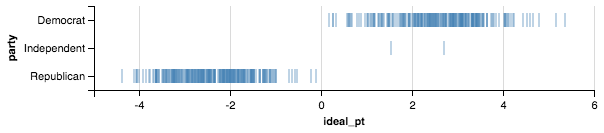

In [59]:
Chart(legislators_pt_df).mark_tick().encode(
    x='ideal_pt:Q',
    y='party:O',
)